# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from IPython.display import display

# The Data

In [2]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')

In [3]:
display(train.head())
display(test.head())

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


,comment_text
id,
6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
6102620,::Kentuckiana is colloquial. Even though the ...
14563293,"Hello fellow Wikipedians,\nI have just modifie..."
21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
22982444,== [WIKI_LINK: Talk:Celts] ==


In [4]:
display(train.shape)
display(test.shape)

(95851, 7)

(226998, 1)

We have just under **96,000** training records, and **227,000** test records

Based on the above, there seems to a be a **strong dimension of obscene, toxic insults** in these comments data.... But note: threats are very rare.

Before going any further, let's take a look at a handful of comments:

# Illustrative Records

In [5]:
from pprint import pprint
illustrations = train['comment_text'].sample(5, random_state=42*10)
for i in illustrations:
    pprint(i)
    print('='*80)

('FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH '
 'TO USER JUJUBE!\n'
 'FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH '
 'TO USER JUJUBE!\n'
 'FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH '
 'TO USER JUJUBE!\n'
 'FUCK USER JUJUBE!FUCK WIKIPEDIA!DESTROY USER JUJUBE!DESTROY WIKIPEDIA!DEATH '
 'TO USER JUJUBE!')
('You know what else?  Because of the same type of bias that the guy is '
 "displaying, media reports are frequently biased.  It's like a bias echo "
 'chamber.  They write biased articles, then they come here and use Wikipedia '
 'to trumpet them. Clever, really, but unfair and untruthful.')
'How many niggers does it take to change a light bulb???'
("Treated him poorly huh? I didn't even use an ethnic slur or anything. This "
 "proves that he's a medical student from Pakistan: "
 'https://twitter.com/ashermadan/status/65290935558344705 and '
 'http://www.dailytimes.com.pk/default.asp?page=

Okay, so first pass impression...some people get really angry on the internet. But seriously, of the above five, three are what I would classify as toxic. The first is obscene and threatening, the third is racist and obscene, and the fourth may also be racist but at least seems to target someone personally. The second is scathing, but not toxic, and the last is nearly gibberish.

# Correlation of Toxicity Types

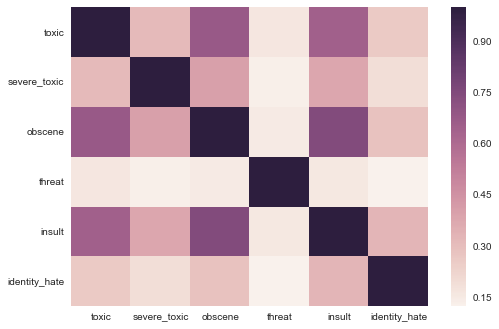

In [6]:
sns.heatmap(train.loc[:, 'toxic':'identity_hate'].corr());

Interestingly, toxic comments actually tend to be shorter by over ten words.

# Text Vectorization

In [7]:
raw_comments = train['comment_text']

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

default_params = dict(
    ngram_range=(1,2),
    stop_words='english',
    max_features=1000,
    binary=True # on hypothesis that this will be effective at detecting obscenity
)

def vectorize_text(corpus=None, kind='CountVectorizer', param_dict=default_params):
    """
    Helper function to vectorize raw comments.
    Fits and transforms either a CountVectorizer or
    TfidfTransformer to a corpus of comments and returns
    a DataFrame with appropriately-labeled axes.
    
    WARNING: Running this function without a reasonably small
    vocabulary may result in memory problems due to the conversion
    to a dense matrix.
    
    """
    if not isinstance(corpus, pd.Series):
        raise ValueError('Enter a Pandas Series object for corpus')
    
    if kind == 'CountVectorizer':
        # Parameters to be set by cross validation
        vectorizer = CountVectorizer(**param_dict)
    elif kind == 'TfidfTransformer':
        vectorizer = TfidfTransformer(**param_dict)
    else:
        raise ValueError('Unrecognized kind')
    
    # Fit-transform vectorizer and put into DataFrame
    vectors = vectorizer.fit_transform(corpus).toarray()
    vectors = pd.DataFrame(vectors, columns=vectorizer.get_feature_names(), index=corpus.index)
    
    # Sort DF columns
    word_frequencies = vectors.sum(axis=0) ; keep_cols = vectorizer.vocabulary_.copy()
    keep_cols = sorted(keep_cols, key=lambda k: word_frequencies[k], reverse=True)
    vectors = vectors[keep_cols]
    
    # Join back up with raw corpus
    vectors = vectors.join(corpus)
    cols = vectors.columns.values[-1:].tolist() + vectors.columns.values[:-1].tolist()
    vectors = vectors[cols]
    
    return vectors

In [9]:
binary_counts = vectorize_text(raw_comments)

In [10]:
binary_counts.head()

,comment_text,article,page,wikipedia,talk,just,like,don,think,know,...,local,parts,ways,speaking,supported,protected,hesitate,guideline,confirm,pro
id,,,,,,,,,,,,,,,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I notice a problem above, namely that the default word token for the CountVectorizer splits on apostrophes, which we probably don't want. This may need more research. That being said, our method of binary-vectorizing the comments worked well.

# Most Common Words Used in Wikipedia Comments

In [11]:
word_frequencies = binary_counts.loc[:, 'article':].sum(axis=0)

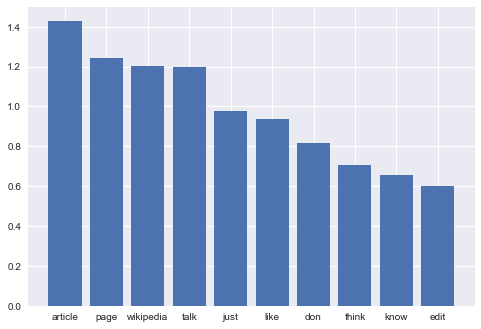

In [14]:
ax = plt.bar(
    range(10), 
    100 * word_frequencies.sort_values(ascending=False)[:10] / word_frequencies.sum(), 
    tick_label=binary_counts.columns[1:11]
);

Of the above top ten most commonly used words, the top four (article, page, wikipedia, talk) all relate directly to editing Wikipedia pages, as does the last one, 'edit'. The others, 'talk', 'just', 'like', 'don' (likely from don't, due to poor tokenization), 'think' and 'know'. Note that both 'think' and 'know' probably are being used by people expressing their opinions in a discussion, which 'just' and 'like' probably facilitate.

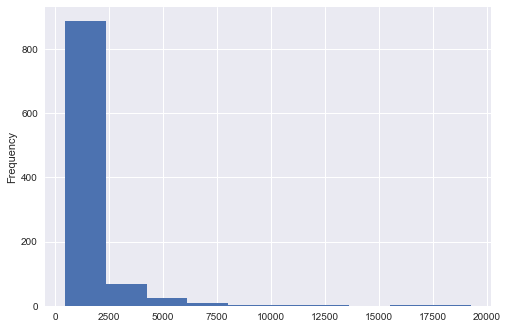

In [15]:
word_frequencies.plot(kind='hist');

# Observations

## Possible indicators of toxicity:
* Lots of punctuation (exclamation points, question marks)
* All-caps or very inconsistent comments (textual screaming)
* Curse words
* Slurs

## Data quality issues:
* What is the best approach to comments that include Wikipedia markup or items like `=Removal from Anti-Semetic category===` and `Semi-protected edit request`? These could also indicate toxicity, particularly if they're indicative of moderator action against the commenter.
* We need a better approach to tokenizing the data, since we have both the above issue and problems with apostrophes (and others I just didn't catch, no doubt).

## Future EDA:
* Correlates and word clouds for each toxicity
* Principal component analysis
* Topic analysis, other dimensionality analysis?
* Feature engineering:
    * Textual screaming
    * Avg word length
    * Obscenity/cursing index
    * Measures of censorship/edits
    
# Analytical questions to consider moving forward:
* Is there a realistic baseline model to use for our project? See ConversationAI's previous work.
* What kinds of models would be appropriate here? The simplest is probably a naive bayes model, and the most complex would be neural networks. In-between would be the various regressions (softmax dependent variable) and support vector machines.
* What's going to be our dimensionality reduction strategy? Since there are so many features to mine out of text data, we need a way to reduce it. The dimensionality analysis from EDA will be helpful here in identifying the best approach. Depending on the model, dimensionality reduction can be achieved in the same step as modeling.
* 